In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import matplotlib.style as style
style.use('seaborn-whitegrid')

import os
import pprint
# import googlemaps
# import time
import pickle
from random import randint
from collections import defaultdict

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
# # Web scraping libraries
# from bs4 import BeautifulSoup
# import selenium
# import requests
# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# from selenium.common.exceptions import NoSuchElementException
# chromedriver = f"/Users/brenner/chromedriver" # path to the chromedriver executable
# os.environ["webdriver.chrome.driver"] = chromedriver

In [3]:
# # Local environment variables
# %load_ext dotenv
# %dotenv

# %load_ext autoreload
# %autoreload 2

In [4]:
# Set pandas options
pd.set_option('max_rows', 10)
# pd.set_option('max_colwidth', -1)
# pd.set_option('display.width', 150)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv('data/portland_listings.csv')

#### Long form output of all fields so that we can see values for all variables

In [34]:
# with pd.option_context('display.max_columns', 100, 'max_colwidth', -1):
#     print(df.head())

      id                         listing_url       scrape_id last_scraped  \
0  7893   https://www.airbnb.com/rooms/7893   20181009011424  2018-10-09    
1  12899  https://www.airbnb.com/rooms/12899  20181009011424  2018-10-09    
2  16688  https://www.airbnb.com/rooms/16688  20181009011424  2018-10-09    
3  25200  https://www.airbnb.com/rooms/25200  20181009011424  2018-10-09    
4  26203  https://www.airbnb.com/rooms/26203  20181009011424  2018-10-09    

                                                name  \
0  North Williams 2brm Home                            
1  Alberta Arts 2 bedroom suite, charming 1906 house   
2  Beautiful condo in downtown Pearl, NW Portland      
3  Flamenco Dream :: hip mississippi ave.              
4  Bluebird @ hip mississippi ave                      

                                                                                                                                                                                                        

In [123]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.iloc[:2,:])

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,7893,https://www.airbnb.com/rooms/7893,20181009011424,2018-10-09,North Williams 2brm Home,"Located on Williams bike corridor, some of Por...",This NE Portland 2 bedroom home is located jus...,"Located on Williams bike corridor, some of Por...",none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/3356bd86-a...,NaN,21489,https://www.airbnb.com/users/show/21489,Jesse,2009-06-14,US,"I love to cook, sail and play the mandolin ver...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/57326937-b...,https://a0.muscache.com/im/pictures/57326937-b...,Piedmont,1,1,"['email', 'phone', 'reviews']",t,f,"Portland, OR, United States",Piedmont,Piedmont,NaN,Portland,OR,97217,Portland,"Portland, OR",US,United States,45.575479,-122.666777,t,House,Entire home/apt,3,1.0,2.0,2.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",""I...",NaN,$175.00,NaN,NaN,NaN,NaN,1,$0.00,3,30,10 months ago,t,0,0,5,5,2018-10-09,2,2010-02-22,2014-08-12,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,"{OREGON,"" MULTNOMAH"","" PORTLAND""}",f,f,flexible,f,f,1,0.02
1,12899,https://www.airbnb.com/rooms/12899,20181009011424,2018-10-09,"Alberta Arts 2 bedroom suite, charming 1906 house",Settle in to a space of your own. You'll have ...,We live in a neighborhood of beautiful gardens...,Settle in to a space of your own. You'll have ...,none,We're within walking distance of a grocery and...,We welcome musicians and even have a guitar fo...,Parking is readily available in front of our h...,"Guests have the whole upstairs, two bedrooms, ...",We let our guests determine their level of int...,Please no smoking. The space is not child-proo...,NaN,NaN,https://a0.muscache.com/im/pictures/225005/cf0...,NaN,49682,https://www.airbnb.com/users/show/49682,Ali And David,2009-10-29,"Portland, Oregon, United States","We enjoy cooking, singing, hiking, bicycles, t...",within an hour,100%,NaN,t,https://a0.muscache.com/im/users/49682/profile...,https://a0.muscache.com/im/users/49682/profile...,Concordia,1,1,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Portland, OR, United States",Concordia,Concordia,NaN,Portland,OR,97211,Portland,"Portland, OR",US,United States,45.564010,-122.634717,t,Guest suite,Private room,3,1.0,2.0,2.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,""Pet...",NaN,$65.00,$475.00,"$1,600.00",$0.00,$20.00,2,$15.00,2,730,a week ago,t,17,47,59,299,2018-10-09,497,2010-01-24,2018-10-03,98.0,10.0,10.0,10.0,10.0,10.0,10.0,t,14-218887-000-00-HO,"{OREGON,"" MULTNOMAH"","" PORTLAND""}",f,f,moderate,f,f,1,4.69


#### Create a dataframe for just the host's property descriptions, summary and notes

In [9]:
df_descriptions = df[['id','host_id', 'summary', 'space', 'description', 'neighborhood_overview',
       'notes', 'host_about']]

# Save the new dataframe to CSV so we can use it later
# df_descriptions.to_csv('data/listing_descriptions.csv')

In [10]:
# 

#### Data exploration & cleaning

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5405 entries, 0 to 5404
Data columns (total 96 columns):
id                                  5405 non-null int64
listing_url                         5405 non-null object
scrape_id                           5405 non-null int64
last_scraped                        5405 non-null object
name                                5405 non-null object
summary                             5192 non-null object
space                               4593 non-null object
description                         5392 non-null object
experiences_offered                 5405 non-null object
neighborhood_overview               4266 non-null object
notes                               3595 non-null object
transit                             4355 non-null object
access                              4301 non-null object
interaction                         4314 non-null object
house_rules                         4309 non-null object
thumbnail_url                       0 no

In [27]:
df.shape

(5405, 96)

In [9]:
df['last_scraped'].value_counts()

2018-10-09    5404
2018-10-12       1
Name: last_scraped, dtype: int64

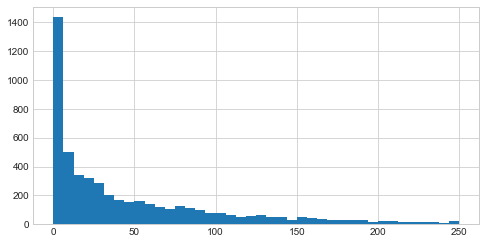

In [11]:
fig, ax = plt.subplots(figsize=(8,4))
plt.hist(df['number_of_reviews'], bins=40, range=(0,250));

In [7]:
df['review_scores_rating'].head()

0    100.0
1     98.0
2     97.0
3     92.0
4     92.0
Name: review_scores_rating, dtype: float64

In [115]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [39]:
df.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,7893,https://www.airbnb.com/rooms/7893,20181009011424,2018-10-09,North Williams 2brm Home,"Located on Williams bike corridor, some of Por...",This NE Portland 2 bedroom home is located jus...,"Located on Williams bike corridor, some of Por...",none,NaN,...,t,NaN,"{OREGON,"" MULTNOMAH"","" PORTLAND""}",f,f,flexible,f,f,1,0.02


In [82]:
df2 = df[['id', 'host_id', 'host_listings_count',
       'host_total_listings_count',
       'neighbourhood', 'zipcode','latitude', 'longitude',
       'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities',
       'price', 'guests_included','number_of_reviews',
       'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'reviews_per_month']]

In [83]:
df2['instant_bookable'] = df2['instant_bookable'].apply(lambda x: 1 if x=='t' else 0)

/Users/brenner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [85]:
df2.loc[:, ['accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities',
       'price','guests_included','number_of_reviews',
       'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'reviews_per_month']]

,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,3,1.0,2.0,2.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",""I...",$175.00,1,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0.02
1,3,1.0,2.0,2.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,""Pet...",$65.00,2,497,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,4.69
2,8,2.0,2.0,3.0,Airbed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$275.00,6,40,97.0,10.0,10.0,10.0,10.0,10.0,9.0,1,2.27
3,2,1.0,1.0,1.0,Real Bed,"{Wifi,Kitchen,""Pets live on this property"",Dog...",$69.00,1,33,92.0,9.0,9.0,10.0,10.0,10.0,9.0,0,0.32
4,2,1.0,1.0,1.0,Real Bed,"{Wifi,Kitchen,""Pets live on this property"",Dog...",$69.00,1,27,92.0,9.0,10.0,9.0,10.0,10.0,9.0,0,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5400,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Pets allowed"",""Pets li...",$60.00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
5401,4,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",$77.00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
5402,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",$99.00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
5403,3,1.0,0.0,2.0,Real Bed,"{Wifi,Heating,""Smoke detector"",""Carbon monoxid...",$80.00,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [107]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5405 entries, 0 to 5404
Data columns (total 28 columns):
id                             5405 non-null int64
host_id                        5405 non-null int64
host_listings_count            5405 non-null int64
host_total_listings_count      5405 non-null int64
neighbourhood                  5095 non-null object
zipcode                        5343 non-null object
latitude                       5405 non-null float64
longitude                      5405 non-null float64
property_type                  5405 non-null object
room_type                      5405 non-null object
accommodates                   5405 non-null int64
bathrooms                      5402 non-null float64
bedrooms                       5403 non-null float64
beds                           5403 non-null float64
bed_type                       5405 non-null object
amenities                      5405 non-null object
price                          5405 non-null int64
guests_inc

#### Change price from a string to an integer, removing dollar sign and commas (e.g. $2,500 -> 2500)

In [99]:
# Change price from a string to an integer, removing dollar sign and commas (e.g. $2,500 -> 2500)
df2['price'] = df2['price'].apply(lambda x: int(x.replace('$','').replace(',','').split('.')[0]))

/Users/brenner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


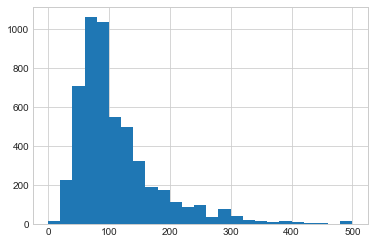

In [106]:
plt.hist(df2['price'], bins=25, range=(0,500));

#### Identify and drop listings with 0 reviews, if desired

In [111]:
# Identify and drop listings with 0 reviews, if desired
zero_reviews = df[df['number_of_reviews']==0].index
df.drop(labels=zero_reviews, axis='index')

In [128]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5405 entries, 0 to 5404
Data columns (total 28 columns):
id                             5405 non-null int64
host_id                        5405 non-null int64
host_listings_count            5405 non-null int64
host_total_listings_count      5405 non-null int64
neighbourhood                  5095 non-null object
zipcode                        5343 non-null object
latitude                       5405 non-null float64
longitude                      5405 non-null float64
property_type                  5405 non-null object
room_type                      5405 non-null object
accommodates                   5405 non-null int64
bathrooms                      5402 non-null float64
bedrooms                       5403 non-null float64
beds                           5403 non-null float64
bed_type                       5405 non-null object
amenities                      5405 non-null object
price                          5405 non-null int64
guests_inc

In [126]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df2.iloc[:2,:])

,id,host_id,host_listings_count,host_total_listings_count,neighbourhood,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,7893,21489,1,1,Piedmont,97217,45.575479,-122.666777,House,Entire home/apt,3,1.0,2.0,2.0,Real Bed,"{TV,Wifi,Kitchen,""Free parking on premises"",""I...",175,1,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0.02
1,12899,49682,1,1,Concordia,97211,45.564010,-122.634717,Guest suite,Private room,3,1.0,2.0,2.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,""Pet...",65,2,497,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,4.69


#### Save newer, smaller dataframe

In [132]:
df2.to_csv('data/cleaned_df.csv')